In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import plot_candlestick, plot_equity_curve

sns.set_style("darkgrid")
sns.set_palette("pastel")

In [3]:
LOG_DIR = '../.log/'

BACKTEST_LOG = f"{LOG_DIR}backtest.json"
MARKET_LOG = f"{LOG_DIR}market.json"
PORTFOLIO_LOG = f"{LOG_DIR}portfolio.json"
SIGNAL_LOG = f"{LOG_DIR}signal.json"
POSITION_LOG = f"{LOG_DIR}position.json"

In [4]:
def read_and_flatten(json_log):
    df = pd.read_json(json_log)
    return pd.json_normalize(df.to_dict(orient='records'))

backtest_df_flat = read_and_flatten(BACKTEST_LOG)
market_df_flat = read_and_flatten(MARKET_LOG)
signal_df_flat = read_and_flatten(SIGNAL_LOG)
position_df_flat = read_and_flatten(POSITION_LOG)
portfolio_df_flat = read_and_flatten(PORTFOLIO_LOG)

In [5]:
symbols_timeframes = backtest_df_flat[['symbol.name', 'timeframe']].drop_duplicates().values.tolist()
symbols_timeframes.sort(key=lambda x: x[0])

print(f"Total: {len(symbols_timeframes)}")

Total: 3


In [6]:
filtered_signal_df = signal_df_flat[signal_df_flat['signal.symbol'].isin([x[0] for x in symbols_timeframes]) & 
                                signal_df_flat['signal.timeframe'].isin([x[1] for x in symbols_timeframes])]
signals = signal_df_flat.groupby(['signal.symbol', 'signal.timeframe', 'signal.strategy']).last().reset_index()

signals['stop_loss_distance'] = abs(signals['entry_price'] - signals['stop_loss'])
signals['datetime'] = pd.to_datetime(signals['ohlcv.timestamp'], unit='ms')

signals['hour'] = signals['datetime'].dt.hour
signals['day_of_week'] = signals['datetime'].dt.dayofweek

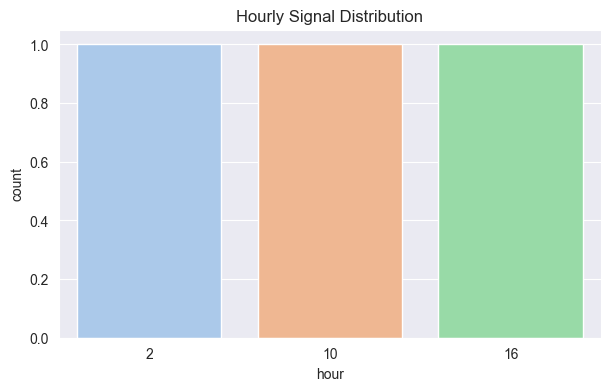

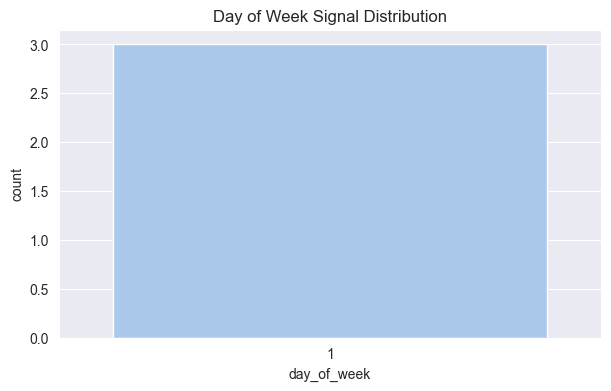

In [7]:
plt.figure(figsize=(7, 4))
sns.countplot(data=signals, x='hour')
plt.title('Hourly Signal Distribution')

plt.figure(figsize=(7, 4))
sns.countplot(data=signals, x='day_of_week')
plt.title('Day of Week Signal Distribution')

plt.show()


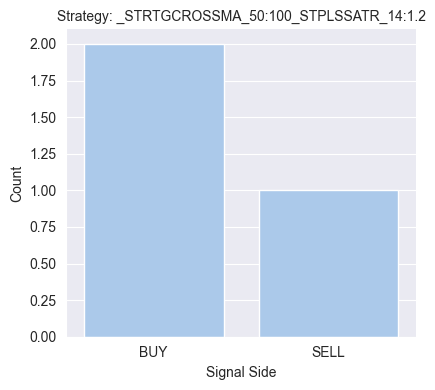

In [8]:
g = sns.FacetGrid(data=signals, col="signal.strategy", col_wrap=2, height=4, sharey=False)
g.map(sns.countplot, "signal.side", order=["BUY", "SELL"])

g.set_axis_labels("Signal Side", "Count")
g.set_titles("Strategy: {col_name}")

plt.show()

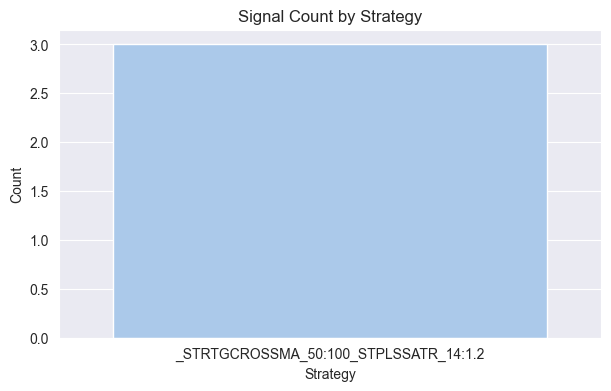

In [9]:
plt.figure(figsize=(7, 4))
sns.countplot(data=signals, x='signal.strategy')
plt.title('Signal Count by Strategy')
plt.xlabel('Strategy')
plt.ylabel('Count')
plt.show()

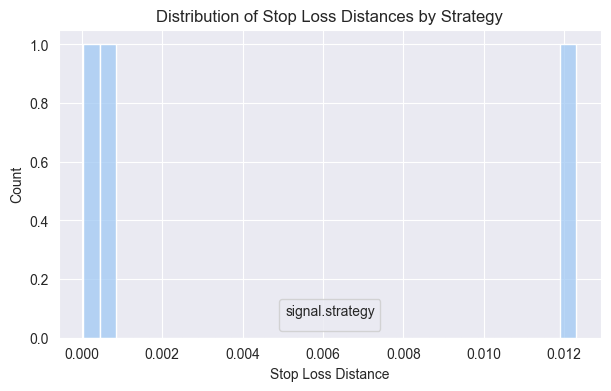

In [10]:
plt.figure(figsize=(7, 4))

sns.histplot(data=signals, x='stop_loss_distance', hue='signal.strategy', bins=30, kde=False, multiple="stack")

plt.title('Distribution of Stop Loss Distances by Strategy')
plt.xlabel('Stop Loss Distance')
plt.ylabel('Count')
plt.show()


In [11]:
filtered_portfolio_df = portfolio_df_flat[portfolio_df_flat['symbol'].isin([x[0] for x in symbols_timeframes]) & 
                                portfolio_df_flat['timeframe'].isin([x[1] for x in symbols_timeframes])]
portfolio = filtered_portfolio_df.groupby(['symbol', 'timeframe', 'strategy']).last().reset_index()
portfolio_sorted = portfolio.sort_values(by='performance.total_pnl', ascending=False)

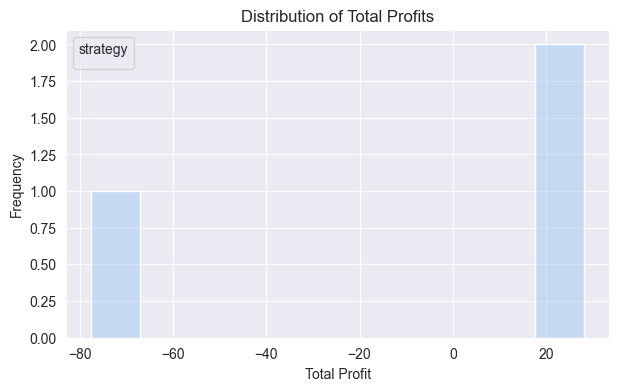

In [12]:
plt.figure(figsize=(7, 4))

sns.histplot(data=portfolio_sorted, x='performance.total_pnl', hue='strategy', kde=False, bins=10)

plt.title('Distribution of Total Profits')
plt.xlabel('Total Profit')
plt.ylabel('Frequency')

plt.show()

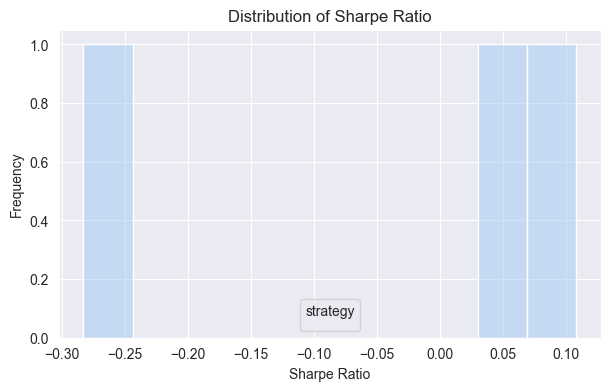

In [13]:
plt.figure(figsize=(7, 4))

sns.histplot(data=portfolio_sorted, x='performance.sharpe_ratio', hue='strategy', kde=False, bins=10)

plt.title('Distribution of Sharpe Ratio')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frequency')

plt.show()

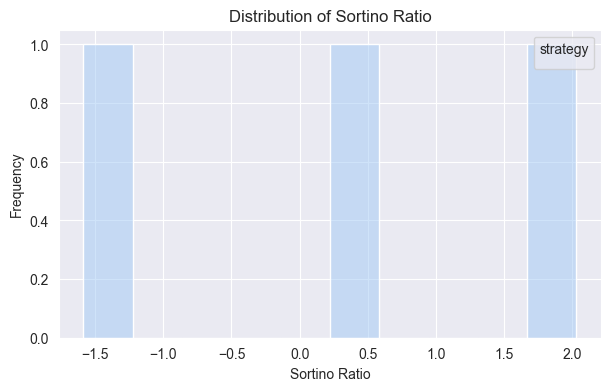

In [14]:
plt.figure(figsize=(7, 4))

sns.histplot(data=portfolio_sorted, x='performance.sortino_ratio', hue='strategy', kde=False, bins=10)

plt.title('Distribution of Sortino Ratio')
plt.xlabel('Sortino Ratio')
plt.ylabel('Frequency')

plt.show()

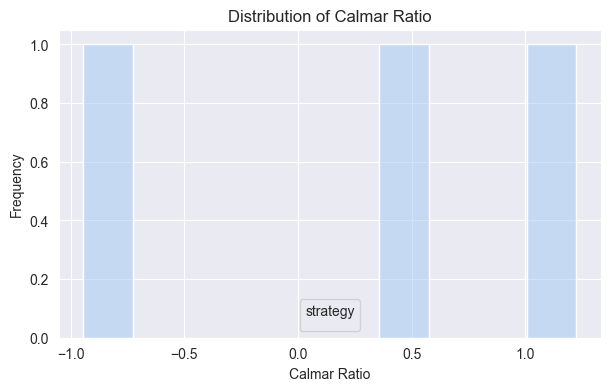

In [15]:
plt.figure(figsize=(7, 4))

sns.histplot(data=portfolio_sorted, x='performance.calmar_ratio', hue='strategy', kde=False, bins=10)

plt.title('Distribution of Calmar Ratio')
plt.xlabel('Calmar Ratio')
plt.ylabel('Frequency')

plt.show()

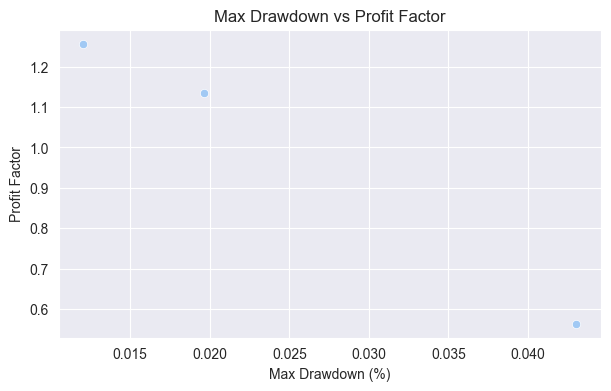

In [16]:
plt.figure(figsize=(7, 4))

sns.scatterplot(data=portfolio, x="performance.max_drawdown", y="performance.profit_factor")

plt.title('Max Drawdown vs Profit Factor')
plt.xlabel('Max Drawdown (%)')
plt.ylabel('Profit Factor')

plt.show()

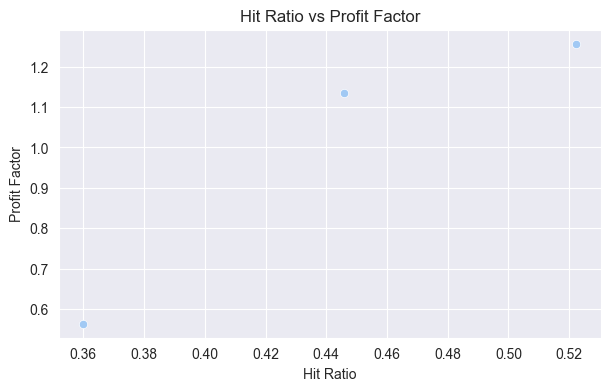

In [17]:
plt.figure(figsize=(7, 4))

sns.scatterplot(data=portfolio, x="performance.hit_ratio", y="performance.profit_factor")

plt.title('Hit Ratio vs Profit Factor')
plt.xlabel('Hit Ratio')
plt.ylabel('Profit Factor')

plt.show()

In [18]:
position_df_flat = position_df_flat[(position_df_flat['meta.name'] == 'PositionClosed')]

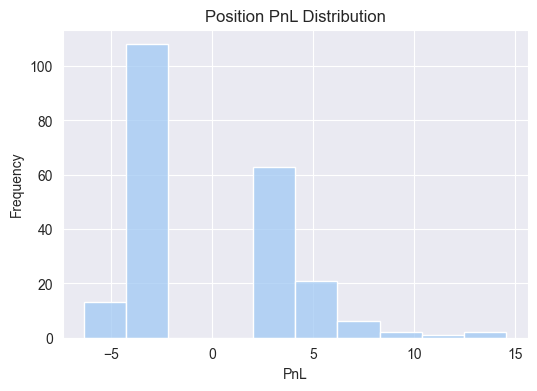

In [19]:
def plot_pnl_distribution(data):
    plt.figure(figsize=(6, 4))
    sns.histplot(data=data, x="position.pnl", kde=False, bins=10)
    plt.title("Position PnL Distribution")
    plt.xlabel("PnL")
    plt.ylabel("Frequency")
    plt.show()


plot_pnl_distribution(position_df_flat)

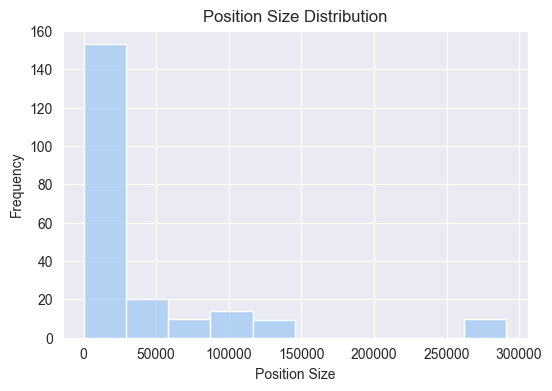

In [20]:
def plot_position_size_distribution(data):
    plt.figure(figsize=(6, 4))
    sns.histplot(data=data, x="position.size", kde=False, bins=10)
    plt.title("Position Size Distribution")
    plt.xlabel("Position Size")
    plt.ylabel("Frequency")
    plt.show()

plot_position_size_distribution(position_df_flat)

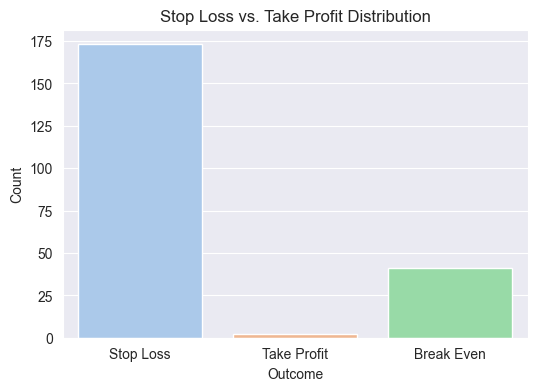

In [21]:
def classify_outcome(row):
    if row['position.exit_price'] <= row['position.stop_loss_price']:
        return 'Stop Loss'
    elif row['position.exit_price'] >= row['position.take_profit_price']:
        return 'Take Profit'
    else:
        return 'Break Even'

position_df_flat['Outcome'] = position_df_flat.apply(classify_outcome, axis=1)

def plot_stop_loss_vs_take_profit(data):
    plt.figure(figsize=(6, 4))
    sns.countplot(x="Outcome", data=data, order=['Stop Loss', 'Take Profit', 'Break Even'])
    plt.title("Stop Loss vs. Take Profit Distribution")
    plt.xlabel("Outcome")
    plt.ylabel("Count")
    plt.show()

plot_stop_loss_vs_take_profit(position_df_flat)

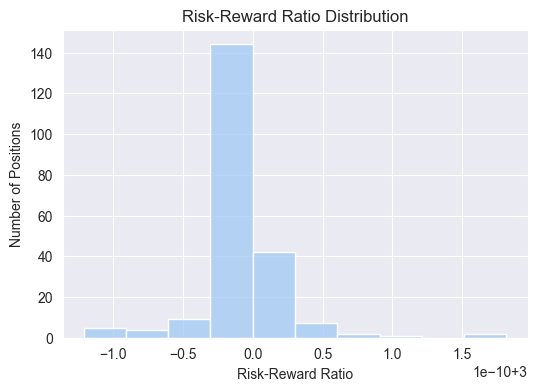

In [22]:
position_df_flat['Risk'] = position_df_flat.apply(
    lambda x: x['position.entry_price'] - x['position.stop_loss_price'] if x['position.side'] == 'long' else x['position.stop_loss_price'] - x['position.entry_price'], 
    axis=1
)
position_df_flat['Reward'] = position_df_flat.apply(
    lambda x: x['position.take_profit_price'] - x['position.entry_price'] if x['position.side'] == 'long' else x['position.entry_price'] - x['position.take_profit_price'], 
    axis=1
)

position_df_flat['Risk-Reward Ratio'] = position_df_flat['Reward'] / position_df_flat['Risk']

plt.figure(figsize=(6, 4))
sns.histplot(position_df_flat['Risk-Reward Ratio'], kde=False, bins=10)
plt.title('Risk-Reward Ratio Distribution')
plt.xlabel('Risk-Reward Ratio')
plt.ylabel('Number of Positions')
plt.grid(True)
plt.show()

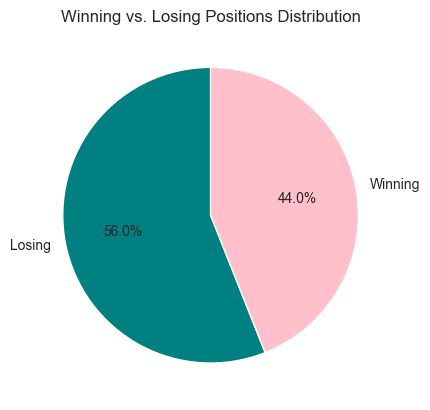

In [23]:
position_df_flat['Position Result'] = position_df_flat['position.pnl'].apply(lambda x: 'Winning' if x > 0 else 'Losing')

result_counts = position_df_flat['Position Result'].value_counts()

result_counts.plot.pie(autopct='%1.1f%%', colors=["teal", "pink"], startangle=90)
plt.title('Winning vs. Losing Positions Distribution')
plt.ylabel('')
plt.show()

In [24]:
top_gains = portfolio_sorted[
    (portfolio_sorted['performance.total_trades'] > 10) & (portfolio_sorted['performance.total_pnl'] > 40)
].head(10)
gains = top_gains[['symbol', 'timeframe', 'strategy']].drop_duplicates().values.tolist()

for symbol, timeframe, strategy in gains:
    df_filtered = portfolio[(portfolio['symbol'] == symbol) & 
                            (portfolio['timeframe'] == timeframe) & 
                            (portfolio['strategy'] == strategy)]
    
    fig = plot_equity_curve(df_filtered, symbol, timeframe, strategy)
    fig.show()

In [25]:
top_losses = portfolio_sorted[(portfolio_sorted['performance.total_pnl'] < 40)].tail(20)
losses = top_losses[['symbol', 'timeframe', 'strategy']].drop_duplicates().values.tolist()

for symbol, timeframe, strategy in losses:
    df_filtered = portfolio[(portfolio['symbol'] == symbol) & 
                            (portfolio['timeframe'] == timeframe) & 
                            (portfolio['strategy'] == strategy)]
    
    fig = plot_equity_curve(df_filtered, symbol, timeframe, strategy)
    fig.show()

In [26]:
symbol_dataframes = {}

rename_map = {
    'ohlcv.timestamp': 'timestamp',
    'ohlcv.open': 'open',
    'ohlcv.high': 'high',
    'ohlcv.low': 'low',
    'ohlcv.close': 'close',
    'ohlcv.volume': 'volume'
}

ohlcv_cols_to_keep = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
signal_cols_to_keep = ['signal.side']
position_cols_to_keep = ['position.side', 'position.size', 'position.entry_price', 'position.exit_price', 'position.stop_loss_price', 'position.take_profit_price', 'position.trade_time', 'position.pnl']

data = gains if len(gains) else losses

for symbol, timeframe, strategy in data:
    if symbol is np.nan:
        continue
    
    symbol_df = market_df_flat[(market_df_flat['symbol.name'] == symbol) & (market_df_flat['timeframe'] == timeframe)]
    signal_df = signal_df_flat[(signal_df_flat['signal.symbol'] == symbol) & 
                               (signal_df_flat['signal.timeframe'] == timeframe) & 
                               (signal_df_flat['signal.strategy'] == strategy)]

    position_df = position_df_flat[(position_df_flat['position.signal.symbol'] == symbol) &
                                   (position_df_flat['position.signal.timeframe'] == timeframe) &
                                   (position_df_flat['position.signal.strategy'] == strategy)]
    
    ohlcv_df = symbol_df[list(rename_map.keys())].copy()
    ohlcv_df = ohlcv_df.rename(columns=rename_map)
    ohlcv_df['symbol'] = symbol
    ohlcv_df['timeframe'] = timeframe
    ohlcv_df['strategy'] = strategy
    ohlcv_df['timestamp'] = pd.to_datetime(ohlcv_df['timestamp'], unit='ms')

    signal_df = signal_df.rename(columns={'ohlcv.timestamp': 'timestamp'})
    signal_df['timestamp'] = pd.to_datetime(signal_df['timestamp'], unit='ms')

    position_df = position_df.rename(columns={'position.open_timestamp': 'timestamp'})
    position_df['timestamp'] = pd.to_datetime(position_df['timestamp'], unit='ms')

    merged_signal_ohlcv = pd.merge(ohlcv_df, signal_df, on='timestamp', how='outer')
    
    merged_df = pd.merge(merged_signal_ohlcv, position_df, on='timestamp', how='outer')

    final_df = merged_df[ohlcv_cols_to_keep + signal_cols_to_keep + position_cols_to_keep]

    symbol_dataframes[(symbol, timeframe)] = final_df

In [27]:
fig = plot_candlestick(symbol_dataframes, 1)
fig.show()